In [289]:
import pandas as pd
import numpy as np
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix, average_precision_score

In [29]:
time_site_pairs_train = pd.read_csv("~data/train_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_val = pd.read_csv("~data/validation_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_test = pd.read_csv("~data/test_labels_mean_zero.csv")[['time', 'site']]

In [4]:
df_merged_zero = pd.read_csv("~data/df_merged_zero_15x15_final.csv")
df_merged_neg = pd.read_csv("~data/df_merged_neg_15x15_final.csv")

## Grid Search to Find the Best Model 

In [118]:
def get_train_test(dataset):
    
    df_train = dataset.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
    df_test = dataset.merge(time_site_pairs_val, on=['time', 'site'], how='inner')

    df_train.drop(['time', 'site'], axis=1, inplace=True)
    df_test.drop(['time', 'site'], axis=1, inplace=True)

    y_train = df_train.pop('riskLevelLabel')
    y_test = df_test.pop('riskLevelLabel')

    X_train = df_train
    X_test = df_test
    
    return X_train, y_train, X_test, y_test

In [227]:
df_train = df_merged_zero.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_zero.merge(time_site_pairs_val, on=['time', 'site'], how='inner')
df_train

,site,time,riskLevelLabel,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,...,SPM_15x15_q1,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3
0,ukc1101-06000,2020-05-14,0,0.014399,0.648437,9.016005,0.720255,1.359252,26.936116,0.014399,...,5.846387,0.720255,1.359252,26.936116,0.014399,0.648437,5.846387,0.720255,1.359252,26.936116
1,ukc1101-06000,2020-05-16,0,0.000000,0.000000,1.135922,0.263305,2.588783,5.632908,0.000000,...,1.135922,0.263305,2.588783,5.632908,0.000000,0.000000,1.135922,0.263305,2.588783,5.632908
2,ukc1101-06000,2020-05-17,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ukc1101-06000,2020-05-18,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ukc1101-06000,2020-05-19,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112261,ukk4307-33900,2022-09-17,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
112262,ukk4307-33900,2022-09-26,0,0.000000,0.000000,7.356489,0.183889,3.869243,3.158081,0.000000,...,7.356489,0.183889,3.869243,3.158081,0.000000,0.000000,7.356489,0.183889,3.869243,3.158081
112263,ukk4307-33900,2022-09-28,0,0.000000,0.000000,4.906127,0.142344,5.219365,2.063839,0.000000,...,4.906127,0.142344,5.219365,2.063839,0.000000,0.000000,4.906127,0.142344,5.219365,2.063839
112264,ukk4307-33900,2022-09-29,0,0.000000,0.000000,9.181858,0.151466,4.857575,2.291730,0.000000,...,9.181858,0.151466,4.857575,2.291730,0.000000,0.000000,9.181858,0.151466,4.857575,2.291730


In [119]:
def rf_result(X_train, y_train, X_test, y_test, model_name):
    
    result = []
    i = 1

    param_grid = {
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 3],
        'n_estimators': [300, 500, 1000]
    }

    best_score = 0
    best_model = None
    
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        max_features = params['max_features']
        max_depth = params['max_depth']
        min_samples_split = params['min_samples_split']
        min_samples_leaf = params['min_samples_leaf']
        n_estimators = params['n_estimators']
    
        print('Progress', model_name,':', i,'/', 
              len(param_grid['max_features'])*len(param_grid['max_depth'])*len(param_grid['min_samples_split'])*len(param_grid['min_samples_leaf'])*len(param_grid['n_estimators']),
              '  ', max_features,'|', max_depth,'|',min_samples_split,'|', min_samples_leaf,'|', n_estimators)
              
        start_time = datetime.now()

        rf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_features=max_features,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=42, 
                                    class_weight='balanced',
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)
        y_pred_proba = rf.predict_proba(X_test)[:, 1]

        accuracy = np.mean(y_pred == y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        res = {'Precision': precision,
               'Recall': recall,
               'f1': f1,
               'acc': accuracy,
               'AUC': auc,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}

        res['#'] = i
        result.append(res)

        # check if the best model
        if f1 > best_score:
            best_score = f1
            best_model = rf
            print('f1 score:', f1, '**Best so far**')
        else: print('f1 score:', f1)

        end_time = datetime.now()
        run_time = end_time - start_time
        print('training time:', run_time)
        print('')

        i += 1
    
    joblib.dump(best_model, model_name+".joblib")                
    return result

In [120]:
results = []

X_train_neg, y_train_neg, X_test_neg, y_test_neg = get_train_test(df_merged_neg)
X_train_zero, y_train_zero, X_test_zero, y_test_zero = get_train_test(df_merged_zero)

In [121]:
%%time
result_neg = rf_result(X_train_neg, y_train_neg, X_test_neg, y_test_neg, 'best_rf_model_neg')
df_results_neg = pd.DataFrame(result_neg)
df_results_neg

Progress best_rf_model_neg : 1 / 162    sqrt | None | 2 | 1 | 300
f1 score: 0.07793439956627811 **Best so far**
training time: 0:00:27.439301

Progress best_rf_model_neg : 2 / 162    sqrt | None | 2 | 1 | 500
f1 score: 0.07793968146391055 **Best so far**
training time: 0:00:44.754219

Progress best_rf_model_neg : 3 / 162    sqrt | None | 2 | 1 | 1000
f1 score: 0.07794496407753829 **Best so far**
training time: 0:01:25.804449

Progress best_rf_model_neg : 4 / 162    sqrt | None | 2 | 2 | 300
f1 score: 0.07814722015304394 **Best so far**
training time: 0:00:26.332477

Progress best_rf_model_neg : 5 / 162    sqrt | None | 2 | 2 | 500
f1 score: 0.07828795882432615 **Best so far**
training time: 0:00:42.796832

Progress best_rf_model_neg : 6 / 162    sqrt | None | 2 | 2 | 1000
f1 score: 0.07828795882432615
training time: 0:01:25.235007

Progress best_rf_model_neg : 7 / 162    sqrt | None | 2 | 3 | 300
f1 score: 0.07827205633421357
training time: 0:00:25.673332

Progress best_rf_model_neg : 

,Precision,Recall,f1,acc,AUC,max_features,max_depth,min_samples_split,min_samples_leaf,#
0,0.042054,0.530933,0.077934,0.636417,0.626579,sqrt,NaN,2,1,1
1,0.042057,0.530933,0.077940,0.636444,0.627637,sqrt,NaN,2,1,2
2,0.042060,0.530933,0.077945,0.636471,0.627417,sqrt,NaN,2,1,3
3,0.042166,0.532779,0.078147,0.636230,0.629283,sqrt,NaN,2,2,4
4,0.042242,0.533703,0.078288,0.636310,0.628319,sqrt,NaN,2,2,5
...,...,...,...,...,...,...,...,...,...,...
157,0.042184,0.536473,0.078218,0.634066,0.638947,log2,20.0,10,2,158
158,0.042190,0.536473,0.078228,0.634119,0.638685,log2,20.0,10,2,159
159,0.042317,0.538319,0.078466,0.634066,0.639681,log2,20.0,10,3,160
160,0.042226,0.537396,0.078299,0.633852,0.639552,log2,20.0,10,3,161


In [122]:
df_results_neg.sort_values(by=['f1'], ascending=False)

,Precision,Recall,f1,acc,AUC,max_features,max_depth,min_samples_split,min_samples_leaf,#
119,0.043880,0.649123,0.082203,0.580514,0.640106,log2,10.0,5,1,120
118,0.043863,0.649123,0.082174,0.580354,0.639249,log2,10.0,5,1,119
113,0.043839,0.649123,0.082131,0.580113,0.639439,log2,10.0,2,2,114
131,0.043797,0.650046,0.082066,0.579151,0.639634,log2,10.0,10,2,132
127,0.043795,0.650046,0.082061,0.579125,0.640048,log2,10.0,10,1,128
...,...,...,...,...,...,...,...,...,...,...
151,0.042088,0.534626,0.078032,0.634386,0.639987,log2,20.0,5,3,152
142,0.042088,0.534626,0.078032,0.634386,0.639987,log2,20.0,2,3,143
2,0.042060,0.530933,0.077945,0.636471,0.627417,sqrt,NaN,2,1,3
1,0.042057,0.530933,0.077940,0.636444,0.627637,sqrt,NaN,2,1,2


In [123]:
%%time
result_zero = rf_result(X_train_zero, y_train_zero, X_test_zero, y_test_zero, 'best_rf_model_zero')
df_results_zero = pd.DataFrame(result_zero)
df_results_zero

Progress best_rf_model_zero : 1 / 162    sqrt | None | 2 | 1 | 300
f1 score: 0.07793439956627811 **Best so far**
training time: 0:00:28.088805

Progress best_rf_model_zero : 2 / 162    sqrt | None | 2 | 1 | 500
f1 score: 0.07793968146391055 **Best so far**
training time: 0:00:44.709724

Progress best_rf_model_zero : 3 / 162    sqrt | None | 2 | 1 | 1000
f1 score: 0.07794496407753829 **Best so far**
training time: 0:01:29.499378

Progress best_rf_model_zero : 4 / 162    sqrt | None | 2 | 2 | 300
f1 score: 0.07814722015304394 **Best so far**
training time: 0:00:26.225623

Progress best_rf_model_zero : 5 / 162    sqrt | None | 2 | 2 | 500
f1 score: 0.07828795882432615 **Best so far**
training time: 0:00:42.454664

Progress best_rf_model_zero : 6 / 162    sqrt | None | 2 | 2 | 1000
f1 score: 0.07828795882432615
training time: 0:01:28.586915

Progress best_rf_model_zero : 7 / 162    sqrt | None | 2 | 3 | 300
f1 score: 0.07827205633421357
training time: 0:00:27.097210

Progress best_rf_model

,Precision,Recall,f1,acc,AUC,max_features,max_depth,min_samples_split,min_samples_leaf,#
0,0.042054,0.530933,0.077934,0.636417,0.626545,sqrt,NaN,2,1,1
1,0.042057,0.530933,0.077940,0.636444,0.627643,sqrt,NaN,2,1,2
2,0.042060,0.530933,0.077945,0.636471,0.627435,sqrt,NaN,2,1,3
3,0.042166,0.532779,0.078147,0.636230,0.629276,sqrt,NaN,2,2,4
4,0.042242,0.533703,0.078288,0.636310,0.628315,sqrt,NaN,2,2,5
...,...,...,...,...,...,...,...,...,...,...
157,0.042184,0.536473,0.078218,0.634066,0.638955,log2,20.0,10,2,158
158,0.042190,0.536473,0.078228,0.634119,0.638687,log2,20.0,10,2,159
159,0.042317,0.538319,0.078466,0.634066,0.639681,log2,20.0,10,3,160
160,0.042226,0.537396,0.078299,0.633852,0.639551,log2,20.0,10,3,161


In [124]:
df_results_zero.sort_values(by=['f1'], ascending=False)

,Precision,Recall,f1,acc,AUC,max_features,max_depth,min_samples_split,min_samples_leaf,#
119,0.043880,0.649123,0.082203,0.580514,0.640106,log2,10.0,5,1,120
118,0.043863,0.649123,0.082174,0.580354,0.639248,log2,10.0,5,1,119
113,0.043839,0.649123,0.082131,0.580113,0.639439,log2,10.0,2,2,114
131,0.043797,0.650046,0.082066,0.579151,0.639634,log2,10.0,10,2,132
127,0.043795,0.650046,0.082061,0.579125,0.640048,log2,10.0,10,1,128
...,...,...,...,...,...,...,...,...,...,...
151,0.042088,0.534626,0.078032,0.634386,0.639986,log2,20.0,5,3,152
142,0.042088,0.534626,0.078032,0.634386,0.639986,log2,20.0,2,3,143
2,0.042060,0.530933,0.077945,0.636471,0.627435,sqrt,NaN,2,1,3
1,0.042057,0.530933,0.077940,0.636444,0.627643,sqrt,NaN,2,1,2


## Performance on testset

In [9]:
best_rf_neg = joblib.load("best_rf_model_neg.joblib")
best_rf_zero = joblib.load("best_rf_model_zero.joblib")

In [34]:
def get_performance_rf(model, dataset):

        df_test = dataset.merge(time_site_pairs_test, on=['time', 'site'], how='inner')
        df_test.drop(['time', 'site'], axis=1, inplace=True)

        y_test = df_test.pop('riskLevelLabel')
        X_test = df_test

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = np.mean(y_pred == y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        # Plot Confusion Matrix
        plot_confusion_matrix(y_test, y_pred)

        plot_curve(roc_auc, y_test, y_pred_proba, pr_auc, precision_curve, recall_curve)

        return {'Precision': precision,
                'Recall': recall,
                'f1': f1,
                'acc': accuracy,
                'ROC-AUC': roc_auc,
                'PR-AUC': pr_auc}
    
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def plot_curve(roc_auc, y_test, y_pred_proba, average_precision, precision_curve, recall_curve):
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    positive_class_ratio = sum(y_test) / len(y_test)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.',label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=15)

    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, marker='.', label='PR curve (AP = %0.4f)' % average_precision)
    plt.axhline(y=positive_class_ratio, color="gray", linestyle='--', label='Baseline')
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.title('Precision-Recall (PR) Curve', fontsize=15)
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=15)

    plt.tight_layout()
    plt.show()

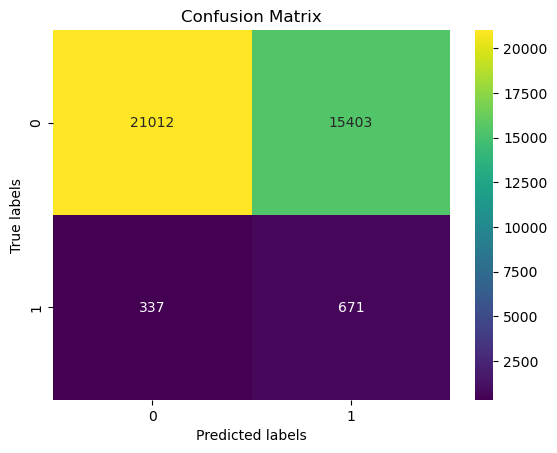

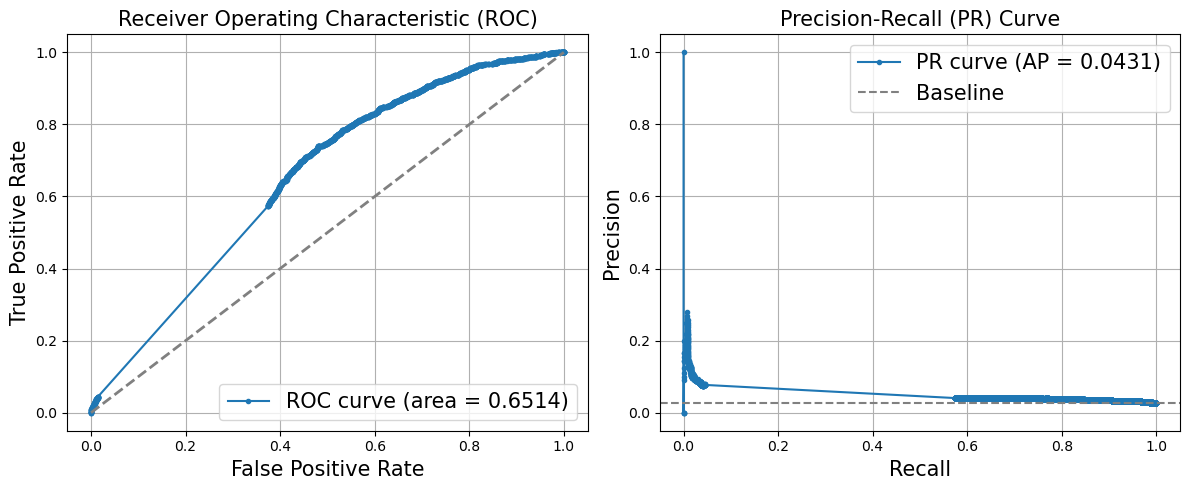

In [35]:
final_performance = []

res = get_performance_rf(best_rf_neg, df_merged_neg)
res['Dataset'] = 'df_merged_neg'
final_performance.append(res)

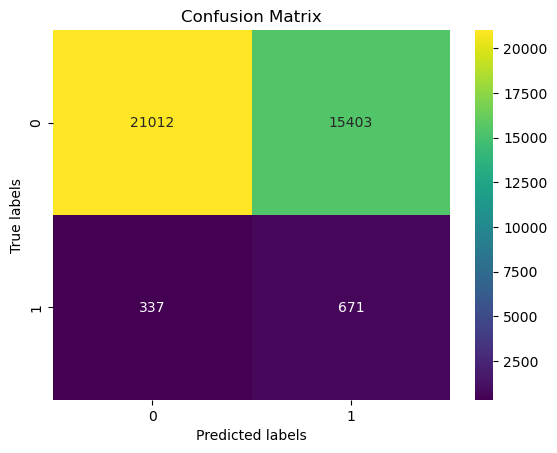

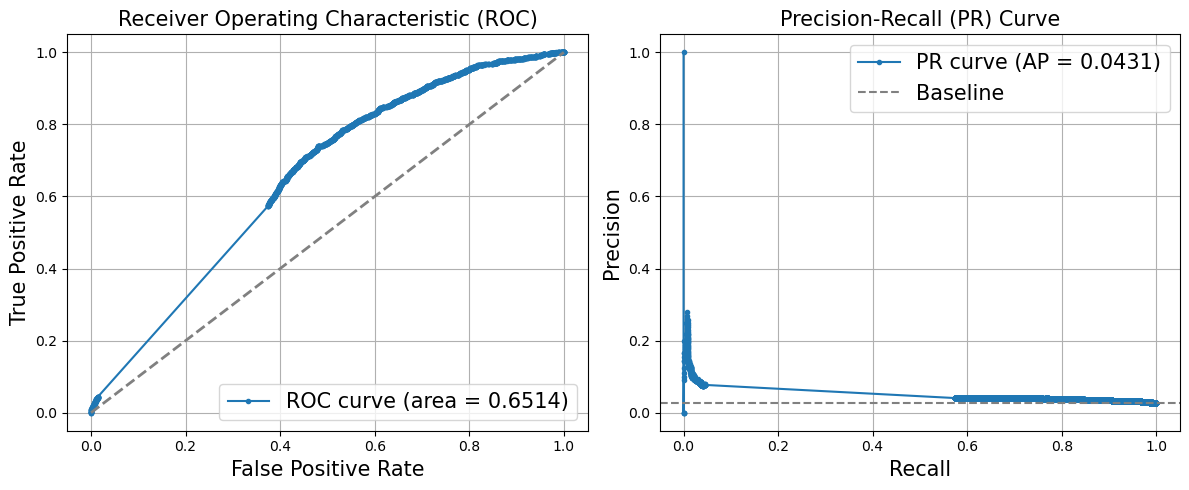

In [36]:
res = get_performance_rf(best_rf_zero, df_merged_zero)
res['Dataset'] = 'df_merged_zero'
final_performance.append(res)

In [224]:
final_performance

[{'Precision': 0.041744432001990794,
  'Recall': 0.6656746031746031,
  'f1': 0.07856222924716076,
  'acc': 0.57940304091067,
  'ROC-AUC': 0.6513916813235432,
  'PR-AUC': 0.0431203711253318,
  'Dataset': 'df_merged_neg'},
 {'Precision': 0.041744432001990794,
  'Recall': 0.6656746031746031,
  'f1': 0.07856222924716076,
  'acc': 0.57940304091067,
  'ROC-AUC': 0.6513921717023117,
  'PR-AUC': 0.04312043113284114,
  'Dataset': 'df_merged_zero'}]

In [225]:
df_final_performance = pd.DataFrame(final_performance)
df_final_performance

,Precision,Recall,f1,acc,ROC-AUC,PR-AUC,Dataset
0,0.041744,0.665675,0.078562,0.579403,0.651392,0.04312,df_merged_neg
1,0.041744,0.665675,0.078562,0.579403,0.651392,0.04312,df_merged_zero


# Performance by Year, Month, and Region

In [177]:
site = pd.read_csv("~data/site.csv")

In [235]:
#add columns 'year' and 'month'
df_merged_zero['year'] = pd.to_datetime(df_merged_zero['time']).dt.year
df_merged_zero['month'] = pd.to_datetime(df_merged_zero['time']).dt.month

df_merged_neg['year'] = pd.to_datetime(df_merged_neg['time']).dt.year
df_merged_neg['month'] = pd.to_datetime(df_merged_neg['time']).dt.month

#add column 'region
site_dict = site.set_index('EUBWID')['region'].to_dict()
df_merged_zero['region'] = df_merged_zero['site'].map(site_dict)
df_merged_neg['region'] = df_merged_neg['site'].map(site_dict)

In [236]:
def get_performance_rf_by_group(model, dataset, group_type):

    df_test = dataset.merge(time_site_pairs_test, on=['time', 'site'], how='inner')
    
    y_test_all = df_test.pop('riskLevelLabel')
    X_test_all = df_test.drop(columns=['time', 'site', 'year', 'month', 'region'])
    
    y_pred_all = model.predict(X_test_all)
    y_pred_proba_all = model.predict_proba(X_test_all)[:, 1]

    df_test['predicted_label'] = y_pred_all
    df_test['predicted_proba'] = y_pred_proba_all
    df_test['true_label'] = y_test_all

    performance_dict = {}
    
    if group_type == 'month':
        df_test = df_test[df_test['month'].between(5, 9)]
    
    for group_value, group in df_test.groupby(group_type):

        y_test = group['true_label']
        y_pred = group['predicted_label']
        y_pred_proba = group['predicted_proba']
        
        accuracy = np.mean(y_pred == y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        count = len(group)
        pos_test = y_test.sum()
        pos_pred = y_pred.sum()

        performance_dict[group_value] = {'Count': count,
                                         '%Pos-Train': pos_test/count*100,
                                         '%Pos-Test': pos_pred/count*100,
                                         'Precision': precision,
                                         'Recall': recall,
                                         'f1': f1,
                                         'acc': accuracy,
                                         'ROC-AUC': roc_auc,
                                         'PR-AUC': pr_auc}
    
    return performance_dict

In [237]:
year_performance_neg = pd.DataFrame(get_performance_rf_by_group(best_rf_neg, df_merged_neg, 'year'))
month_performance_neg = pd.DataFrame(get_performance_rf_by_group(best_rf_neg, df_merged_neg, 'month'))
region_performance_neg = pd.DataFrame(get_performance_rf_by_group(best_rf_neg, df_merged_neg, 'region'))

year_performance_zero = pd.DataFrame(get_performance_rf_by_group(best_rf_zero, df_merged_zero, 'year'))
month_performance_zero = pd.DataFrame(get_performance_rf_by_group(best_rf_zero, df_merged_zero, 'month'))
region_performance_zero = pd.DataFrame(get_performance_rf_by_group(best_rf_zero, df_merged_zero, 'region'))

In [238]:
year_performance_neg.to_csv('year_performance_neg.csv',index=False)
year_performance_neg

,2020,2021,2022
Count,11766.000000,12894.000000,12763.000000
%Pos-Train,3.025667,3.032418,2.044974
%Pos-Test,44.594595,44.982162,39.387291
Precision,0.045931,0.045000,0.033618
Recall,0.676966,0.667519,0.647510
f1,0.086025,0.084316,0.063918
acc,0.564763,0.560338,0.612160
ROC-AUC,0.647389,0.637246,0.667527
PR-AUC,0.049339,0.049147,0.033297


In [239]:
month_performance_neg.to_csv('month_performance_neg.csv',index=False)
month_performance_neg

,5,6,7,8,9
Count,6430.000000,7690.000000,7829.000000,7683.000000,7429.000000
%Pos-Train,1.493002,2.002601,1.903180,3.358063,4.428591
%Pos-Test,38.755832,44.733420,42.930132,41.624365,45.685826
Precision,0.027287,0.030523,0.032431,0.051282,0.062758
Recall,0.708333,0.681818,0.731544,0.635659,0.647416
f1,0.052550,0.058431,0.062108,0.094907,0.114424
acc,0.618663,0.559948,0.579512,0.592867,0.556199
ROC-AUC,0.690454,0.642855,0.669791,0.647265,0.630039
PR-AUC,0.034818,0.030235,0.035760,0.060409,0.062404


In [240]:
region_performance_neg.to_csv('region_performance_neg.csv',index=False)
region_performance_neg

,East Midlands,East of England,London,North East,North West,South East,South West,Yorkshire and The Humber
Count,696.000000,3510.000000,346.000000,2953.000000,2557.000000,7603.000000,17926.000000,1832.000000
%Pos-Train,2.729885,1.823362,4.046243,3.115476,5.123191,2.577930,2.354123,3.820961
%Pos-Test,61.063218,54.301994,100.000000,42.025059,54.986312,40.378798,38.056454,46.834061
Precision,0.032941,0.022036,0.040462,0.054795,0.065434,0.043648,0.039431,0.044289
Recall,0.736842,0.656250,1.000000,0.739130,0.702290,0.683673,0.637441,0.542857
f1,0.063063,0.042640,0.077778,0.102026,0.119714,0.082058,0.074268,0.081897
acc,0.402299,0.462678,0.040462,0.594650,0.470864,0.605682,0.625907,0.534934
ROC-AUC,0.578248,0.582745,0.500000,0.698420,0.584841,0.667661,0.673772,0.546315
PR-AUC,0.044875,0.023288,0.040462,0.054965,0.076794,0.043591,0.042813,0.055673


In [241]:
year_performance_zero.to_csv('year_performance_zero.csv',index=False)
year_performance_zero

,2020,2021,2022
Count,11766.000000,12894.000000,12763.000000
%Pos-Train,3.025667,3.032418,2.044974
%Pos-Test,44.594595,44.982162,39.387291
Precision,0.045931,0.045000,0.033618
Recall,0.676966,0.667519,0.647510
f1,0.086025,0.084316,0.063918
acc,0.564763,0.560338,0.612160
ROC-AUC,0.647391,0.637246,0.667526
PR-AUC,0.049339,0.049147,0.033297


In [242]:
month_performance_zero.to_csv('month_performance_zero.csv',index=False)
month_performance_zero

,5,6,7,8,9
Count,6430.000000,7690.000000,7829.000000,7683.000000,7429.000000
%Pos-Train,1.493002,2.002601,1.903180,3.358063,4.428591
%Pos-Test,38.755832,44.733420,42.930132,41.624365,45.685826
Precision,0.027287,0.030523,0.032431,0.051282,0.062758
Recall,0.708333,0.681818,0.731544,0.635659,0.647416
f1,0.052550,0.058431,0.062108,0.094907,0.114424
acc,0.618663,0.559948,0.579512,0.592867,0.556199
ROC-AUC,0.690454,0.642855,0.669791,0.647267,0.630038
PR-AUC,0.034818,0.030235,0.035760,0.060409,0.062404


In [243]:
region_performance_zero.to_csv('region_performance_zero.csv',index=False)
region_performance_zero

,East Midlands,East of England,London,North East,North West,South East,South West,Yorkshire and The Humber
Count,696.000000,3510.000000,346.000000,2953.000000,2557.000000,7603.000000,17926.000000,1832.000000
%Pos-Train,2.729885,1.823362,4.046243,3.115476,5.123191,2.577930,2.354123,3.820961
%Pos-Test,61.063218,54.301994,100.000000,42.025059,54.986312,40.378798,38.056454,46.834061
Precision,0.032941,0.022036,0.040462,0.054795,0.065434,0.043648,0.039431,0.044289
Recall,0.736842,0.656250,1.000000,0.739130,0.702290,0.683673,0.637441,0.542857
f1,0.063063,0.042640,0.077778,0.102026,0.119714,0.082058,0.074268,0.081897
acc,0.402299,0.462678,0.040462,0.594650,0.470864,0.605682,0.625907,0.534934
ROC-AUC,0.578248,0.582745,0.500000,0.698420,0.584841,0.667666,0.673772,0.546315
PR-AUC,0.044875,0.023288,0.040462,0.054965,0.076794,0.043592,0.042813,0.055673


# Feature Engineered Dataset vs Raw Data

In [ ]:
# Train-test split
df_train = df_merged_zero.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_zero.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (112266, 193)
Training y Shape: (112266,)
Testing X Shape: (37423, 193)
Testing y Shape: (37423,)


In [207]:
def rf(X_train, y_train, X_test, y_test, model_name):
    
    rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    return {'Precision': precision,
            'Recall': recall,
            'f1': f1,
            'acc': accuracy,
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc}

In [ ]:
res = rf(X_train, y_train, X_test, y_test)
res['Dataset'] = 'Engineered'

In [ ]:
results_df_rf = pd.DataFrame([res])
results_df_rf

,Precision,Recall,f1,acc,ROC-AUC,PR-AUC,Dataset
0,0.283217,0.160714,0.205063,0.966438,0.69667,0.141884,Engineered


## Model training on Raw Data

In [193]:
raw_data = pd.read_csv("~data/sites_data_new(6x225).csv")
df_merged_raw = pd.merge(riskforecasting, raw_data, on=['site','time'])

In [196]:
df_merged_raw = df_merged_raw.fillna(0)
df_merged_raw

,site,time,riskLevelLabel,BBP_1,BBP_2,BBP_3,BBP_4,BBP_5,BBP_6,BBP_7,...,CHL_216,CHL_217,CHL_218,CHL_219,CHL_220,CHL_221,CHL_222,CHL_223,CHL_224,CHL_225
0,ukc1101-06000,2020-05-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.581898,32.167812,30.977350,29.331144,27.752580,27.542662,27.677454,25.904116,23.733080,21.709576
1,ukc1101-06000,2020-05-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ukc1101-06000,2020-05-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,6.141244,5.893124,5.551386,5.345596,5.279991,5.216403
3,ukc1101-06000,2020-05-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ukc1101-06000,2020-05-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187107,ukk4307-33900,2022-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187108,ukk4307-33900,2022-09-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187109,ukk4307-33900,2022-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187110,ukk4307-33900,2022-09-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.587374,2.538867,2.614031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [208]:
results_raw = []

X_train_raw, y_train_raw, X_test_raw, y_test_raw = get_train_test(df_merged_raw)
res = rf(X_train_raw, y_train_raw, X_test_raw, y_test_raw)
res['Dataset'] = 'df_raw'
results_raw.append(res)
results_raw

[{'Precision': 0.039448599501393164,
  'Recall': 0.5337301587301587,
  'f1': 0.07346715826846921,
  'acc': 0.6373887716110413,
  'ROC-AUC': 0.6702498370852757,
  'PR-AUC': 0.08674395093750349,
  'Dataset': 'df_raw'}]

### df_merged_zero

In [209]:
X_train_zero, y_train_zero, X_test_zero, y_test_zero = get_train_test(df_merged_zero)
res = rf(X_train_zero, y_train_zero, X_test_zero, y_test_zero)
res['Dataset'] = 'Engineered'
results_raw.append(res)
results_raw

[{'Precision': 0.039448599501393164,
  'Recall': 0.5337301587301587,
  'f1': 0.07346715826846921,
  'acc': 0.6373887716110413,
  'ROC-AUC': 0.6702498370852757,
  'PR-AUC': 0.08674395093750349,
  'Dataset': 'df_raw'},
 {'Precision': 0.03978021978021978,
  'Recall': 0.5386904761904762,
  'f1': 0.07408923454768726,
  'acc': 0.6373353285412714,
  'ROC-AUC': 0.6278647655226675,
  'PR-AUC': 0.1181486996064479,
  'Dataset': 'Engineered'}]

## Performance by clusters

In [5]:
cluster_pairs_test = pd.read_csv("~data/test_with_cluster.csv")

In [15]:
cluster_pairs_test

,site,time,riskLevelLabel,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,cluster
0,ukc1202-06650,2020-06-05,1,0.002986,0.039705,1.283574,0.149732,4.921273,2.247580,0.002986,...,0.142911,5.236460,2.083618,0.002986,0.039705,1.283574,0.142911,5.236460,2.083618,2
1,ukc1202-06700,2020-08-24,1,0.002458,0.093960,2.077496,0.183432,4.100962,3.201868,0.002458,...,0.183432,4.068698,3.201868,0.002458,0.093960,2.077496,0.183432,4.100962,3.201868,2
2,ukc2103-04600,2020-08-24,1,0.004586,0.026278,3.875391,0.174393,4.114664,2.894618,0.004586,...,0.128400,6.233653,1.770035,0.004586,0.026278,1.813883,0.128400,6.233653,1.770035,2
3,ukc2103-04600,2022-09-29,1,0.020971,0.146831,6.199709,0.188662,3.752482,3.292190,0.020971,...,0.190572,3.707183,3.348240,0.020266,0.123182,5.114015,0.191137,3.709506,3.366300,2
4,ukc2103-04700,2020-08-24,1,0.004586,0.026278,1.880023,0.131147,6.193217,1.846722,0.004586,...,0.131147,6.144756,1.846722,0.004586,0.026278,1.880023,0.131147,6.193217,1.846722,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ukk4304-34700,2022-09-26,1,0.042722,0.116843,8.494947,0.205334,3.423756,3.785667,0.042722,...,0.205334,3.423756,3.785667,0.042722,0.116843,8.494947,0.205334,3.423756,3.785667,2
96,ukk4304-34800,2020-08-18,1,0.044307,0.185059,7.211779,0.190118,3.757423,3.347346,0.044307,...,0.185305,3.757423,3.197144,0.044307,0.185059,10.558348,0.190118,3.831927,3.347346,2
97,ukk4305-26200,2021-06-23,1,0.003192,0.072590,0.261229,0.125868,6.125638,1.685297,0.003192,...,0.124253,6.125638,1.637736,0.003192,0.072590,0.468821,0.125868,6.125638,1.685297,2
98,ukk4306-22800,2020-06-11,1,0.015995,0.057877,5.296386,0.120047,6.405754,1.545960,0.015995,...,0.120047,6.405754,1.545960,0.015995,0.057877,5.296386,0.120047,6.405754,1.545960,2


In [12]:
def get_performance_rf_by_cluster(model):

    df_test = cluster_pairs_test.copy()
    
    y_test_all = df_test.pop('riskLevelLabel')
    X_test_all = df_test.drop(columns=['time', 'site', 'cluster'])
    
    y_pred_all = model.predict(X_test_all)
    y_pred_proba_all = model.predict_proba(X_test_all)[:, 1]

    df_test['predicted_label'] = y_pred_all
    df_test['predicted_proba'] = y_pred_proba_all
    df_test['true_label'] = y_test_all

    performance_dict = {}
    
    for group_value, group in df_test.groupby('cluster'):

        y_test = group['true_label']
        y_pred = group['predicted_label']
        y_pred_proba = group['predicted_proba']
        
        accuracy = np.mean(y_pred == y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        performance_dict[group_value] = {'Precision': precision,
                                         'Recall': recall,
                                         'f1': f1,
                                         'acc': accuracy}
    
    return performance_dict

In [13]:
clusters_performance_zero = pd.DataFrame(get_performance_rf_by_cluster(best_rf_zero))
clusters_performance_zero

,1,2
Precision,1.000000,1.000000
Recall,0.023256,0.052632
f1,0.045455,0.100000
acc,0.023256,0.052632


# s2s3 Comparison

In [4]:
time_site_pairs_test_s2s3 = pd.read_csv("~data/time_site_pairs_S2S3_train.csv")[['time', 'site']]
time_site_pairs_train_s2s3 = pd.read_csv("~data/time_site_pairs_S2S3_test.csv")[['time', 'site']]

### S2

In [309]:
df_s2 = pd.read_csv('~data/df_merged_mean_51x51.csv')

In [310]:
# Train-test split
df_train = df_s2.merge(time_site_pairs_train_s2s3, on=['time', 'site'], how='inner')
df_test = df_s2.merge(time_site_pairs_test_s2s3, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (10557, 313)
Training y Shape: (10557,)
Testing X Shape: (41668, 313)
Testing y Shape: (41668,)


In [311]:
def rf_result(X_train, y_train, X_test, y_test):
    # fit a random forest to the data
    rf = RandomForestClassifier(class_weight='balanced',n_jobs=-1, random_state = 42)
    rf.fit(X_train, y_train)

    # make predictions
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    return {'Precision': precision,
            'Recall': recall,
            'f1': f1,
            'acc': accuracy,
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc}

In [312]:
res = rf_result(X_train, y_train, X_test, y_test)
res['Dataset'] = 'S2'

## S3

In [316]:
df_s3 = pd.read_csv("~data/df_merged_neg_15x15_final.csv")
df_s3

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel
0,2020-02-29,ukk4304-34200,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.914567,0.398097,0.214138,0.000000,0.000000,0.346636,0.907182,0.369711,0.196058,1
1,2020-03-01,ukk4305-25400,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.905581,0.473189,0.173679,0.000000,0.000000,0.198644,0.899170,0.462575,0.161943,1
2,2020-03-12,uke1200-08100,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.917918,0.383813,0.232332,0.000000,0.000000,0.259476,0.910494,0.355530,0.212664,1
3,2020-03-15,ukd1103-45920,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.910715,0.423031,0.195198,0.000000,0.000000,0.327689,0.903420,0.395205,0.178891,1
4,2020-05-14,ukc1101-06000,0.000000,0.000000,0.172873,0.0,0.0,0.0,0.000000,0.000000,...,0.953924,0.345838,0.503972,0.991532,0.887653,0.152995,0.956492,0.319529,0.549381,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119185,2022-11-04,ukj3400-18000,0.996448,0.868351,0.199695,0.0,0.0,0.0,0.996448,0.868351,...,0.915569,0.377575,0.219419,0.996325,0.858259,0.241710,0.912615,0.364994,0.224096,0
119186,2022-12-02,ukk3103-29500,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.900469,0.592162,0.157594,0.000000,0.000000,0.127632,0.894746,0.671483,0.147580,1
119187,2022-12-02,ukk3103-29500,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.900469,0.592162,0.157594,0.000000,0.000000,0.127632,0.894746,0.671483,0.147580,0
119188,2022-12-07,ukk3103-29100,0.000000,0.000000,0.111443,0.0,0.0,0.0,0.000000,0.000000,...,0.909437,0.381248,0.189416,0.000000,0.000000,0.111631,0.911294,0.407130,0.219305,1


In [11]:
# Train-test split
df_train = df_s3.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_s3.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

In [12]:
res = rf_result(X_train, y_train, X_test, y_test)
res['Dataset'] = 'S3'

In [13]:
results_df_rf.loc[len(results_df_rf)] = res
results_df_rf

,Precision,Recall,f1,acc,ROC-AUC,PR-AUC,Dataset
0,0.916667,0.166667,0.282051,0.973659,0.789758,0.353064,S2
1,0.026316,0.017857,0.021277,0.956726,0.500289,0.029257,S3


# Window Size Comparison

In [291]:
time_site_pairs_test_s2s3 = pd.read_csv("~data/time_site_pairs_S2S3_train.csv")[['time', 'site']]
time_site_pairs_train_s2s3 = pd.read_csv("~data/time_site_pairs_S2S3_test.csv")[['time', 'site']]

## S2

In [301]:
df_train = df_s2.merge(time_site_pairs_train_s2s3, on=['time', 'site'], how='inner')
df_test = df_s2.merge(time_site_pairs_test_s2s3, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11', '13x13', '15x15']

cols = []
performance = {}

for dim in dims:

    cols.extend([col for col in X_train.columns if dim in col])

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    performance[dim] = rf_result(X_train_new, y_train, X_test_new, y_test)

performance

{'1x1': {'Precision': 0.2,
  'Recall': 0.00375234521575985,
  'f1': 0.007366482504604051,
  'acc': 0.9741288278775079,
  'ROC-AUC': 0.5791576917485649,
  'PR-AUC': 0.042739931894978656},
 '3x3': {'Precision': 0.4117647058823529,
  'Recall': 0.006566604127579738,
  'f1': 0.012927054478301017,
  'acc': 0.974344820965729,
  'ROC-AUC': 0.6495911831809318,
  'PR-AUC': 0.08013201975997816},
 '5x5': {'Precision': 0.39285714285714285,
  'Recall': 0.010318949343339587,
  'f1': 0.020109689213893965,
  'acc': 0.9742728232696554,
  'ROC-AUC': 0.6575484433016683,
  'PR-AUC': 0.08958333297504703},
 '7x7': {'Precision': 0.44,
  'Recall': 0.010318949343339587,
  'f1': 0.020164986251145735,
  'acc': 0.974344820965729,
  'ROC-AUC': 0.6729836851260943,
  'PR-AUC': 0.08792723796824739},
 '9x9': {'Precision': 0.3548387096774194,
  'Recall': 0.010318949343339587,
  'f1': 0.020054694621695533,
  'acc': 0.9742008255735817,
  'ROC-AUC': 0.6766311593075804,
  'PR-AUC': 0.08657973856311596},
 '11x11': {'Precisio

In [302]:
pd.DataFrame(performance)

,1x1,3x3,5x5,7x7,9x9,11x11,13x13,15x15
Precision,0.200000,0.411765,0.392857,0.440000,0.354839,0.451613,0.484848,0.428571
Recall,0.003752,0.006567,0.010319,0.010319,0.010319,0.013133,0.015009,0.014071
f1,0.007366,0.012927,0.020110,0.020165,0.020055,0.025524,0.029117,0.027248
acc,0.974129,0.974345,0.974273,0.974345,0.974201,0.974345,0.974393,0.974297
ROC-AUC,0.579158,0.649591,0.657548,0.672984,0.676631,0.674042,0.676736,0.668928
PR-AUC,0.042740,0.080132,0.089583,0.087927,0.086580,0.087235,0.090297,0.086537


## S3

In [305]:
#neg
df_train = df_merged_neg.merge(time_site_pairs_train_s2s3, on=['time', 'site'], how='inner')
df_test = df_merged_neg.merge(time_site_pairs_test_s2s3, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11', '13x13', '15x15']

cols = []
performance = {}

for dim in dims:

    cols.extend([col for col in X_train.columns if dim in col])

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    performance[dim] = rf_result(X_train_new, y_train, X_test_new, y_test)

In [306]:
pd.DataFrame(performance)

,1x1,3x3,5x5,7x7,9x9,11x11,13x13,15x15
Precision,0.047539,0.047350,0.047468,0.047368,0.047283,0.047378,0.047368,0.047354
Recall,0.461909,0.459981,0.460945,0.459981,0.459016,0.459981,0.459981,0.459981
f1,0.086205,0.085861,0.086072,0.085892,0.085735,0.085907,0.085892,0.085869
acc,0.756288,0.756240,0.756384,0.756336,0.756360,0.756384,0.756336,0.756264
ROC-AUC,0.637934,0.640769,0.646035,0.638711,0.643749,0.641397,0.641191,0.642080
PR-AUC,0.040910,0.041358,0.040687,0.040905,0.041377,0.041062,0.040774,0.041739


In [307]:
#zero
df_train = df_merged_zero.merge(time_site_pairs_train_s2s3, on=['time', 'site'], how='inner')
df_test = df_merged_zero.merge(time_site_pairs_test_s2s3, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11', '13x13', '15x15']

cols = []
performance = {}

for dim in dims:

    cols.extend([col for col in X_train.columns if dim in col])

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    performance[dim] = rf_result(X_train_new, y_train, X_test_new, y_test)

In [308]:
pd.DataFrame(performance)

,1x1,3x3,5x5,7x7,9x9,11x11,13x13,15x15
Precision,0.047539,0.047350,0.047468,0.047368,0.047283,0.047378,0.047368,0.047354
Recall,0.461909,0.459981,0.460945,0.459981,0.459016,0.459981,0.459981,0.459981
f1,0.086205,0.085861,0.086072,0.085892,0.085735,0.085907,0.085892,0.085869
acc,0.756288,0.756240,0.756384,0.756336,0.756360,0.756384,0.756336,0.756264
ROC-AUC,0.637909,0.640717,0.646129,0.638736,0.643619,0.641110,0.641233,0.642151
PR-AUC,0.040906,0.041355,0.040696,0.040907,0.041371,0.041053,0.040779,0.041747
